# Love for sandwiches
## Visualization of the data gathered through [Lovac na sendiče](https://chrome.google.com/webstore/detail/lovac-na-sendvi%C4%8De/cebplboeldmlomimakpfhbhojajdpaki)

In this notebook I will explore the data I've gathered.<br>
My main focus is extracting the valid reactions to comments sent in by the user.<br>
<br>
The goal of this code is to figure out the couple of users that yield consistent reactions but still maintain a large percentage of the overall results. As we can see from the data, the large majority of the users only create a couple of reactions, and can be discarded as their answers cannot be easily validated.

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import graphviz
from networkx import draw_spring as draw

from pymongo import MongoClient
client = MongoClient()

blic = client.blic
b92 = client.b92
n1 = client.n1

In [2]:
mpl.rcParams.update({'axes.titlesize': '20'})
mpl.rcParams.update({'axes.labelsize': '15'})
RED = '\033[91m'
BOLD = '\033[1m'
END = '\033[0m'

In [3]:
blic_comments = list(blic.comments.find())
b92_comments = list(b92.comments.find())
n1_comments = list(n1.comments.find())

blic_reactions = list(blic.reactions.find())
b92_reactions = list(b92.reactions.find())
n1_reactions = list(n1.reactions.find())

all_comments = blic_comments + b92_comments + n1_comments
all_reactions = blic_reactions + b92_reactions + n1_reactions

# Comment dictionary with comment_id's as indices
comments_dict = {}
for comment in all_comments:
    # FIXME: For some reason multiple same comments pop up. 
    comment['reactions'] = []
    comments_dict[comment['comment_id']] = comment
    
# Add the reactions to each comment
for reaction in all_reactions:
    if reaction['comment_id'] not in comments_dict:
#         print("Missing comment with ID: %s" % reaction['comment_id'])
        pass
    else:
        comments_dict[reaction['comment_id']]['reactions'].append(reaction)    

## Broj komentara:

In [4]:
print("Blic: %s" % blic.comments.count())
print("B92: %s" % b92.comments.count())
print("N1: %s" % n1.comments.count())
print("Ukupno: %s" % len(all_comments))

Blic: 3629
B92: 2231
N1: 511
Ukupno: 6371


## Broj korisnika:

In [5]:
print("Blic: %s " % len(blic.reactions.distinct('userid')))
print("B92: %s " % len(b92.reactions.distinct('userid')))
print("N1: %s " % len(n1.reactions.distinct('userid')))

user_ids = set()
for reaction in all_reactions:
    user_ids.add(reaction['userid'])
    
print("Ukupan broj korisnika na sva 3 sajta: %s" % len(user_ids))

Blic: 482 
B92: 140 
N1: 49 
Ukupan broj korisnika na sva 3 sajta: 572


## Broj reakcija po komentaru

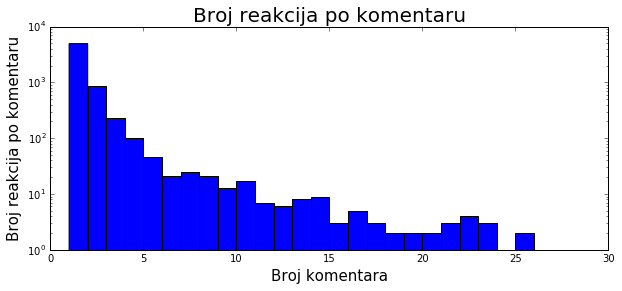

In [6]:
x = [len(x['reactions']) for x in all_comments]

plt.figure(figsize=(10,4))
n, bins, patches = plt.hist(x, range(1,30))

plt.xlabel('Broj komentara')
plt.ylabel('Broj reakcija po komentaru')
plt.yscale('log')
plt.title('Broj reakcija po komentaru')
plt.show()

## Histogram dužina komentara

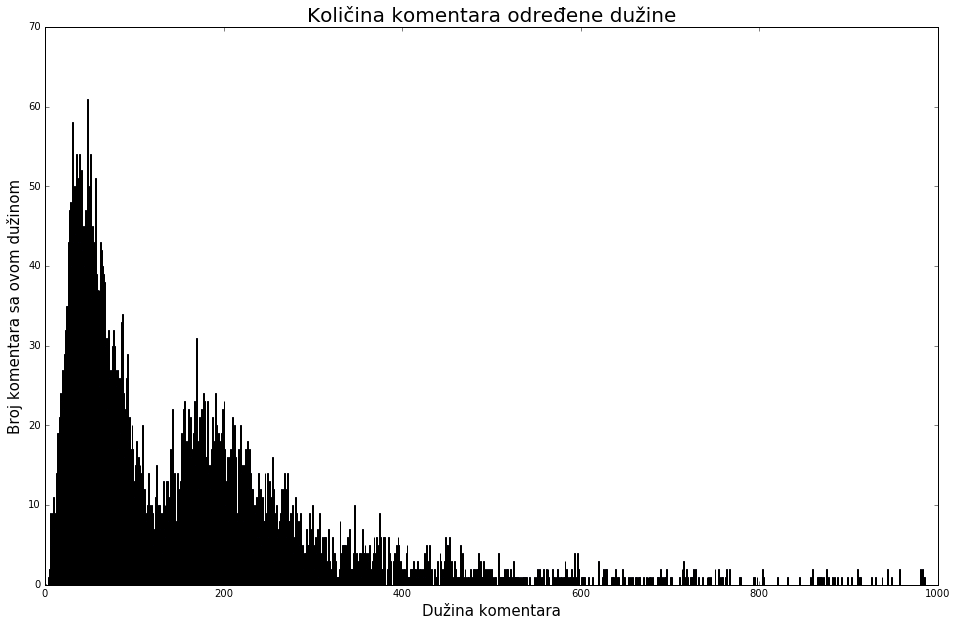

Najduži komentar (2528 karaktera): 
Istinu koju niko neće da objavi niti da preduzme mere kako bi sve stranke potpisale dokument koji bi bio obavezan da se usvoji odnosno donese zakon nakon izbora, bez obzira ko formirao vlast.Tim zakonom bi nakon smanjenja broja zaposlenih u javnim preduzećima išla komisija sastavljena od ... Proširi svevlasti ,opozicije i nestranačkih ljudi.Ta komisija bi proveravala  da li su izmišljena partijska mesta  zadržania,da li su potrebni radnici dobili otkaz......Ukoliko bi se utvrdilo da je tako, u roku od 3 meseca ispraviti nedostatak.Ukoliko se nepreduzme nešto po ovom pitanju Srbija ide u pravcu još jačeg partijskog zapošljavanja.Članska karta ima veći značaj od radne knjižice odnosno od sposobnosti,znanja i poštenja radnika.Većina ljudi koji su nepošteni učlanjeni su u neku stranku kako bi imali prednost, odnosno primali platu iz budžeta za svoj nerad.Ova trenutna opozicija se neprotivi jer i oni su deo sistema,Oko 2/3 vrha u svim  stranakama prima pl

In [7]:
lens = []
for comment in all_comments:
    if comment['comment'] is None:
        comment['comment'] = ""
    lens.append(len(comment['comment']))
       
plt.figure(figsize=(16,10))
n, bins, patches = plt.hist(lens, range(1, 1000))
plt.xlabel(u'Dužina komentara')
plt.ylabel(u'Broj komentara sa ovom dužinom')
plt.title(u'Količina komentara određene dužine')
plt.show()

idx_max = np.argmax(lens)
print("Najduži komentar (%s karaktera): " % len(all_comments[idx_max]['comment']))
print(all_comments[idx_max]['comment'])


## Komentari sa najviše reakcija:

In [8]:
popularity = []
for comment in all_comments:
    popularity.append(len(comment['reactions']))
    
sort_idx = np.argsort(popularity)
for i in range(1,6):
    comment = all_comments[sort_idx[-i]]
    bots = 0; nots = 0
    for reaction in comment['reactions']:
        if reaction['bot'] == 'true':
            bots += 1
        else:
            nots += 1

    print '\x1b[1;31m'+"Bot: %s, not: %s" % (bots, nots)+'\x1b[0m'
#     print "Bot: %s, not: %s" % (bots, nots)
    print comment['comment']
    print ""
    
del popularity, sort_idx

Bot: 27, not: 0
Brze, pametne odluke nase Vlade su za pohvalu.

Bot: 26, not: 0
upravo to,ljudski zivot nema cenu, svaka cast nasoj vladi!!!

Bot: 25, not: 0
test

Bot: 1, not: 24
Gde ti vidis brzinu i razum kad je pola Srbije polavljeno ?
Sta uradise sa parama koje su dobili 2012 godine ?

Bot: 24, not: 0
Samo uz paljivo slusanje mera predostroznosti mozemo pobediti ovu bitku.



## Broj reakcija po korisniku

In [9]:
users = {}
for reaction in all_reactions:
    user_id = reaction['userid']
    
    if user_id in users:
        users[user_id]['reactions'].append(reaction) 
    else:
        users[user_id] = {
            'reactions': [],
            'user_id': user_id
        }

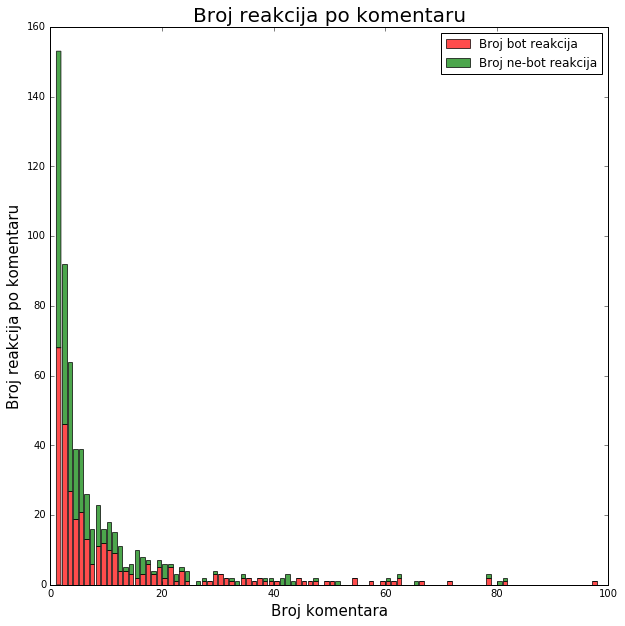

In [10]:
def get_bot_not_counts_per_user(users):
    # Go through each user, count the number of bot and not reactions he made
    # Append them to a list we'll use for the histogram
    bots = []; nots = []
    for user in users.values():
        bot_count = 0; not_count = 0
        for reaction in user['reactions']:
            if reaction['bot'] == 'true':
                bot_count += 1
            else:
                not_count += 1
        
        bots.append(bot_count)
        nots.append(not_count)
        
    return bots, nots
     
    
def plot_reactions_per_user(users):
    bots, nots = get_bot_not_counts_per_user(users)
    
    plt.figure(figsize=(10,10))
    n, bins, patches = plt.hist([bots, nots], range(1,100), color=['red', 'green'], alpha=0.7, stacked=True)

    plt.xlabel('Broj komentara')
    plt.ylabel('Broj reakcija po komentaru')
    plt.title('Broj reakcija po komentaru')
    plt.legend(["Broj bot reakcija", "Broj ne-bot reakcija"])
    plt.show()

plot_reactions_per_user(users)

## Broj korisnika sa prema broju poslatih bot/ne-bot reakcija
X osa je broj bot reakcija nekog korisnika, y osa je broj ne-bot reakcija nekog korisnika. <br>Zanimaju nas korisnici sa velikim brojem reakcija i korisnici koji imaju sličan broj bot i ne-bot reakcija.

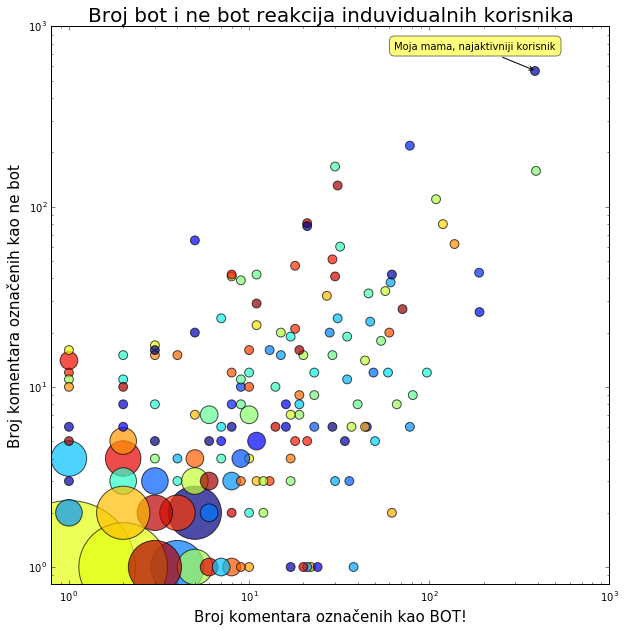

In [11]:
def plot_user_scatter(users):
    bots, nots = get_bot_not_counts_per_user(users)
    botnot = zip(bots, nots)
    x = []; y = []; area = []

    # multiple users have the same bot/not count, 
    # so remove the multiple circles and fill a bigger one
    while len(botnot) > 0:
        bn = botnot[0]
        x.append(bn[0]), y.append(bn[1])
        area.append(botnot.count(bn))
        for i in range(botnot.count(bn)):
            botnot.remove(bn)

    colors = np.random.rand(len(x))
    area = np.array(area)
    min_width = np.pi * 5 ** 2
    area = (area ** 2) * min_width

    plt.figure(figsize=(10,10))
    fig = plt.scatter(x, y, s=area, c=colors, alpha=0.7)

    # labels
    plt.title(u"Broj bot i ne bot reakcija induvidualnih korisnika")
    plt.xlabel(u"Broj komentara označenih kao BOT!")
    plt.ylabel(u"Broj komentara označenih kao ne bot")

    # # log scale
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(0.8, 1000)
    plt.xlim(0.8, 1000)

    # # Majka
    xm = max(bots)
    ym = max(nots)
    plt.annotate(
        "Moja mama, najaktivniji korisnik", 
        xy = (xm, ym), xytext = (20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

    plt.show()
    
plot_user_scatter(users)

## Similarity matrica korisnika
Dva korisnika su slična srazmerno broju komentara na koje su oboje reagovali. <br>
__Matrica ne uzima u obzir da li su korisnici iste reakcije ostavili na neki komentar, samo da li su napravili reakciju__

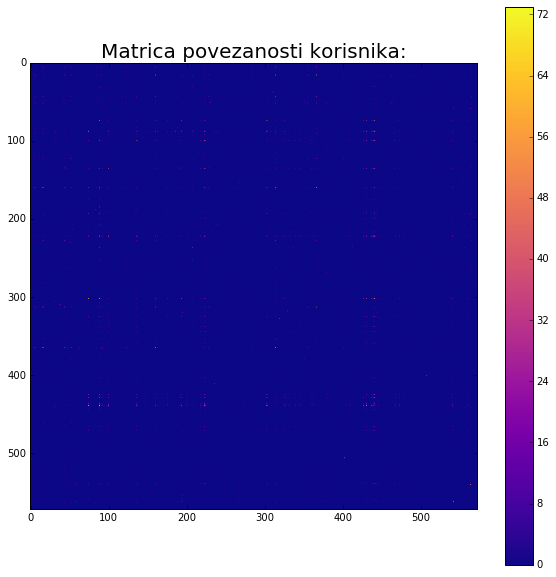

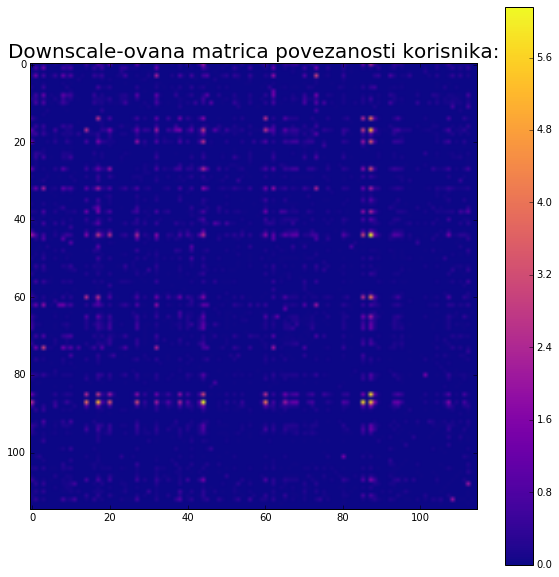

In [12]:
def build_connection_matrix(users):
    """
    Builds a square matrix with the size len(users),
    where each element is the number of comments both users have reacted on.
    Doesn't take into account the type (bot/not) of the reactions.
    """
    matrix = np.zeros((len(users), len(users)))
    
    for f, first in enumerate(users.values()):
        for s, second in enumerate(users.values()):
            # build sets and intersect them 
            comment_ids1 = set([x['comment_id'] for x in first['reactions']])
            comment_ids2 = set([x['comment_id'] for x in second['reactions']])
            matrix[f, s] = len(comment_ids1.intersection(comment_ids2))
                        
    # clear the main diagonal
    for i in range(len(matrix)):
        matrix[i, i] = 0
        
    return matrix
            
    
def build_old_connection_matrix(all_reactions, min_reactions=1):
    user_reactions = dict()

    # attach reactions to its user
    for reaction in all_reactions:
        id = reaction['userid']
        if id not in user_reactions:
            user_reactions[id] = set([reaction['comment_id']])
        else:
            user_reactions[id].add(reaction['comment_id'])
            
    cleaned_users = dict()
    for user_id in user_reactions:
        if len(user_reactions[user_id]) >= min_reactions:
            cleaned_users[user_id] = user_reactions[user_id]
    
    user_reactions = cleaned_users
    
    # compare reaction sets of every two users
    user_matrix = np.zeros((len(user_reactions), len(user_reactions)))
    for fidx, first_reactions in enumerate(user_reactions.values()):
        for sidx, second_reactions in enumerate(user_reactions.values()):
            overlap = first_reactions.intersection(second_reactions)
            user_matrix[fidx, sidx] = len(overlap)

    # clear the main diagonal
    for i in range(len(user_matrix)):
        user_matrix[i, i] = 0
    
    return user_matrix


def downscale(image, block_size=(5,5)):
    from skimage.measure import block_reduce
    return block_reduce(image, block_size, func=np.mean) 
    
# Draw the similarity matrix for all users
connection_matrix = build_connection_matrix(users)
old_matrix = build_old_connection_matrix(all_reactions)

fig, ax = plt.subplots(figsize=(10, 10))
res = ax.imshow(connection_matrix, cmap="plasma")
plt.title("Matrica povezanosti korisnika:")
_ = plt.colorbar(res)

fig, ax = plt.subplots(figsize=(10, 10))
res = ax.imshow(downscale(connection_matrix, block_size=(5,5)), cmap="plasma")
plt.title("Downscale-ovana matrica povezanosti korisnika:")
_ = plt.colorbar(res)

In [46]:
def remove_zero_lines(matrix):
    """
    Many users don't have any connections, and show up as lone points.
    This removes them and leaves only users with at least one connection.
    """
    matrix = matrix[:,~np.all(matrix==0, axis=0)]
    matrix = matrix[~np.all(matrix==0, axis=1)]
    return matrix


def prune_users(users, min_reactions=1):
    """
    Creates a new dict of users with at least min_reactions reactions.
    """
    pruned = {}
    for user_id in users:
        if len(users[user_id]['reactions']) >= min_reactions:
            pruned[user_id] = users[user_id]
    
    return pruned

def trim_matrix(matrix, min_intersect=1):
    """
    Checks if each value is equal or greater than min_intersect,
    converts booleans to integers
    """
    return (matrix >= min_intersect) * 1

def draw_graph(G, title):
    pos = nx.spring_layout(G, iterations=1000)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    nx.draw_networkx_nodes(G, pos, show="ipynb", ax=ax,
        node_size=40,
        alpha=0.35)
    nx.draw_networkx_edges(G, pos, show="ipynb", ax=ax,
        arrows=False,
        alpha=0.1)
    
    _ = plt.title(title)

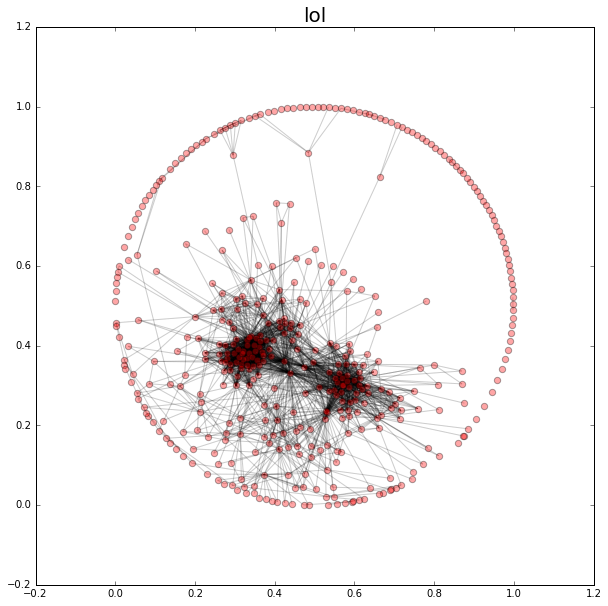

In [47]:
min_reactions = 1
min_intersect = 1

# build a connection matrix of users with at least min_reactions 
connections = build_connection_matrix(prune_users(users, min_reactions))
# removes connections weaker than min_intersect
connections = trim_matrix(connections, min_intersect)

G1 = nx.DiGraph(connections) # without removing zero lines
G2 = nx.DiGraph(remove_zero_lines(connections))

# labels = {}
# for idx, user in enumerate(users):
#     if user == "11111111":
#         labels[idx] = u"\n\nKreten koji mi\nčačka REST endpoint-e"

draw_graph(G1, "lol" )
# fig, ax = plt.subplots(figsize=(10, 10))
# draw(G1, show="ipynb", ax=ax,
# #     weight=connections,
#     iterations=2000,
#     arrows=False,
#     node_size=40,
# #     line_widths=1,
# #     labels=labels,
# #     font_size=20,
#     alpha=0.35)
# _ = plt.title("Korisnici koji su odgovorili na najmanje min_intersect istih komentara su povezani")

# fig, ax = plt.subplots(figsize=(10, 10))
# draw(G2, show="ipynb", ax=ax,
# #     weight=connections,
#     iterations=2000,
#     arrows=False,
#     node_size=40,
# #     line_widths=1,
# #     labels=labels,
# #     font_size=20,
#     alpha=0.35)
# _ = plt.title("Korisnici koji su odgovorili na najmanje min_intersect istih komentara su povezani\nOtklonjeni korisnici koji nemaju nijednu vezu")

In [15]:
min_reactions = 1
min_intersect = 10

sm, users_dict = build_similarity_matrix(all_reactions, min_reactions=min_reactions)
edge_matrix = (sm >= min_intersect) * 1
edge_matrix = remove_zero_lines(edge_matrix)
G = nx.DiGraph(edge_matrix)

fig, ax = plt.subplots(figsize=(15, 15))
draw(G, show="ipynb", ax=ax,
    width=2,
    iterations=200,
    arrows=False,
    node_size=40,
    alpha=0.6)

_ = plt.title("Korisnici koji su odgovorili na najmanje min_intersect istih komentara su povezani")

NameError: name 'build_similarity_matrix' is not defined

In [ ]:
def build_better_similarity_matrix(users, min_reactions=5):
    """
    Builds a similarity matrix between users.
    The similarity between two users is the number of comments they have agreed
    minus the number of comments they have disagreed on.
    """
    ul = len(users)
    matrix = np.zeros((ul, ul))
    
    get_id = lambda x: x['comment_id']
    
    for f, first in enumerate(users.values()):
        if len(first['reactions']) > min_reactions:
            for s, second in enumerate(users.values()):
                if len(second['reactions']) > min_reactions:
                    first_tagged_bot = set(map(get_id, filter(lambda x: x['bot'] == 'true', first['reactions'])))
                    first_tagged_not = set(map(get_id, filter(lambda x: x['bot'] == 'false', first['reactions'])))
                    second_tagged_bot = set(map(get_id, filter(lambda x: x['bot'] == 'true', second['reactions'])))
                    second_tagged_not = set(map(get_id, filter(lambda x: x['bot'] == 'false', second['reactions'])))

                    result = len(set.intersection(first_tagged_bot, second_tagged_bot)) + \
                             len(set.intersection(first_tagged_not, second_tagged_not)) - \
                             len(set.intersection(first_tagged_bot, second_tagged_not)) - \
                             len(set.intersection(first_tagged_not, second_tagged_bot))

                    matrix[f, s] = result
                else:
                    matrix[f, s] = 0
        else:
            matrix[f, s] = 0
                    
    return matrix

edge_matrix = build_better_similarity_matrix(users)

G = nx.DiGraph(edge_matrix)
pos = nx.spring_layout(G, iterations=2000)
fig, ax = plt.subplots(figsize=(15, 15))
nx.draw_networkx_nodes(G, pos, show="ipynb", ax=ax,
    width=2,
    node_size=40)

nx.draw_networkx_edges(G, pos, show="ipynb", ax=ax,
    arrows=False,
    alpha=0.2)


# Draw the similarity matrix for all users
fig, ax = plt.subplots(figsize=(10, 10))
res = ax.imshow(sm0, cmap="plasma")
plt.colorbar(res)